In [1]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
# 下面返回两个值：数据迭代器、字典（每个token对应的下标）
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps) # 时间机器数据集

独热编码：给定一个向量和独热编码的长度，返回用0-1表示的张量

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

如果增加批量的维度呢？小批量形状是(批量大小, 时间步数)，那么独热编码始终都是在最后一个维度增加给定的长度。注意：下面的转置是为了后面读取数据集方便

In [3]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

初始化循环神经网络模型的模型参数

In [4]:
def get_params(vocab_size, num_hiddens, device):
    # 输入使用了one-hot编码，则特征数量变成了token的个数，也就是词典的长度；
    # 输出由于是预测下一个词，因此可以是字典中的每一个词，因此就是个分类问题（vocab_size 个类别）
    num_inputs = num_outputs = vocab_size 

    def normal(shape): # 给定一个形状，生成均值为0方差为1的tensor，最后还乘了0.01
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs)) # 这个是输出时的训练参数
    b_q = torch.zeros(num_outputs, device=device) # 这个是输出层的偏置
    params = [W_xh, W_hh, b_h, W_hq, b_q] # 将所有的参数放在一个list里面，告诉要算梯度
    for param in params:
        param.requires_grad_(True) # 告诉要算梯度
    return params

一个 init_rnn_state 函数在初始化时返回隐藏状态:因为第一个隐藏状态没人给他，所以要初始化

In [5]:
def init_rnn_state(batch_size, num_hiddens, device): # 注意形状是B,H，其中H是我们人为定义的
    return (torch.zeros((batch_size, num_hiddens), device=device),)

下面的rnn函数定义了如何在一个时间步计算隐藏状态和输出

In [6]:
def rnn(inputs, state, params):
    """
    inputs:[T, B, F]，这个F就是vocab_size，也就是字典的长度，这里认为是特征
    state:[B,H]
    params:参数的个数，一维
    """
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs: # 沿着时间的维度遍历，这样就可以直接计算当前时刻到下一时刻的输出了，因此前面的转置是有必要的，不然每次要在这里转置
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q # 当前时刻预测下一个时刻的输出，形状是[B,F]，这个F就是vocab_size，也就是字典的长度，这里认为是特征
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,) # outputs在0维度拼接起来，这样维度就是[B*T, F],这个F就是vocab_size，也就是字典的长度，这里认为是特征

创建一个类来包装这些函数

In [7]:
class RNNModelScratch:  
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        """
         X:[B, T]
         state:[B,H]
        """
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32) # [T, B, F]，这个F就是vocab_size，也就是字典的长度，这里认为是特征
        return self.forward_fn(X, state, self.params) # 放入forword里面，也就是我们前面实现的rnn那个函数，得出输出和隐层

    def begin_state(self, batch_size, device): # 初始状态
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状

In [13]:
num_hiddens = 512 # 隐层的ge'sh
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

首先定义预测函数来生成用户提供的prefix之后的新字符

In [18]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device) # 初始化隐藏状态
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1)) # 把每次时间步上的输出作为下一次的输入，reshape成B=1,T=1
    for y in prefix[1:]:
        _, state = net(get_input(), state) # 不需要预测的输出
        outputs.append(vocab[y]) # 这里用真实的值，目的是把给出的序列信息存入state里面
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs]) # 通过下标转换成真实的字符

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller jhavljwnix'

梯度裁剪
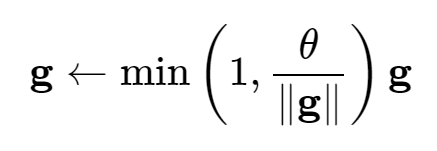

In [20]:
def grad_clipping(net, theta):  # theta就是我们设定的最大的梯度
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params)) # 梯度的二范数（看上面的公式）
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

定义一个函数来训练只有一个迭代周期的模型

In [40]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter: # 这个就是batch之间没有时序关系，因此，每次都进行初始化：初始的隐藏状态
            state = net.begin_state(batch_size=X.shape[0], device=device)
        
        # 如果batch之间有关系，那么就不会每次初始化隐藏状态了，只做detach_()：不把state值改掉，只是在backward的时候，把计算图砍掉了
        # 这个这么做的原因是：batch有时序关系，把前一次的batch信息放入后一个batch里面
        # 把前面的计算图砍掉的原因是：前面的隐藏状态再不用了，因此就不用再每次更新了，减少计算的浪费和时间的加速
        # 如果batch之间有关系，实际上就是每个epoch读取了一个很长的序列
        else: 
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1) # 真实值，转置成[T, B]，再拉成向量
        X, y = X.to(device), y.to(device) # 送入gpu
        y_hat, state = net(X, state) # 得出预测值
        l = loss(y_hat, y.long()).mean() # 求得loss
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1) # 裁剪梯度。
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1) # 裁剪梯度。
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop() # 第一个参数：困惑度；第二个参数：每秒钟跑的次数

训练函数支持从零开始或使用高级API实现的循环神经网络模型

In [38]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss() # 交叉熵损失
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度： {ppl:.1f}, 标记/秒： {speed:.1f}  {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

现在我们可以训练循环神经网络模型

困惑度： 1.0, 标记/秒： 96602.2  cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


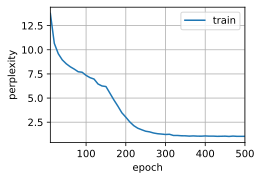

In [39]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

最后，让我们检查一下使用随机抽样方法的结果

困惑度： 1.3, 标记/秒： 96602.5  cuda:0
time travellerit s against reason said filbywhat we move freely 
travellerit s against reason said filbywhat we move freely 


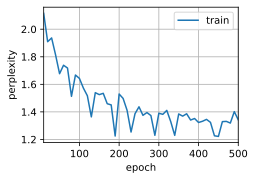

In [41]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)